# Testing LRCT

## What to Test:
    - We want to test LRCT on the following:
        - Single linear split
        - "Checkerboard" classification
        - Single nonlinear split
        - Set of nonlinear splits
        - Iris dataset
        - Cancer dataset

## How to Test (if "real-world" problem):
    - Set of parameters
    - GridSearchCV over the parameter set
    - Test against CART as well

In [1]:
from LRCT import LRCTree
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
sns.set_style('darkgrid')

## Single Linear Split

In this section, we will test how LRCT performs at identifying a single linear split across 2 and 3 variables, both with additional variables as noise and without.  In addition, we will test adding noise to the data and leaving it out

### Across 2 Variables, no Additional Variables, no Noise

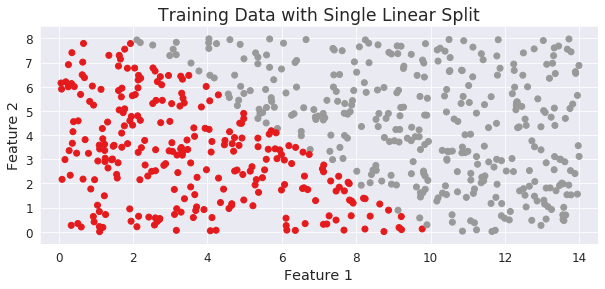

LRCT Performance:
Accuracy: 0.9775
F1 Score: 0.9807280513918629
Confusion Matrix: [[162   4]
 [  5 229]]
AUC Score: 0.9772680465451551
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       166
           1       0.98      0.98      0.98       234

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400




CART Performance:
Accuracy: 0.8575
F1 Score: 0.8683602771362587
Confusion Matrix: [[155  11]
 [ 46 188]]
AUC Score: 0.8685768715889197
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       166
           1       0.94      0.80      0.87       234

    accuracy                           0.86       400
   macro avg       0.86      0.87      0.86       400
weighted avg       0.87      0.86      0.86       400



In [9]:
#Generate the fake data
np.random.seed(5648)
two_var_x = np.random.random((1000, 2))
two_var_x[:, 0] = two_var_x[:, 0] * 14
two_var_x[:, 1] = two_var_x[:, 1] * 8
df = pd.DataFrame(two_var_x, columns = ['col_0', 'col_1'])
target = df.apply(lambda row : 1 if row.col_1 > -1*row.col_0 + 10 else 0, axis = 1)
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size = 0.4, random_state = 21)

#Plot the data
plt.figure(figsize = (10, 4))
plt.scatter(x_train.col_0, x_train.col_1, c = y_train, cmap = 'Set1')
plt.title('Training Data with Single Linear Split', fontsize = 'xx-large')
plt.xlabel('Feature 1', fontsize = 'x-large')
plt.ylabel('Feature 2', fontsize = 'x-large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.xlim(-0.5, 14.5)
plt.ylim(-0.5, 8.5)
plt.savefig('linear_split_initial.png')
plt.show()

def run_expt(lrct_params, cart_params, x_train, x_test, y_train, y_test):
    lrct = LRCTree(**lrct_params).fit(x_train, y_train)
    cart = DecisionTreeClassifier(**cart_params).fit(x_train, y_train)
    
    lrct_preds = lrct.predict(x_test)
    cart_preds = cart.predict(x_test)
    lrct_probs = lrct.predict_proba(x_test)[:, 1]
    cart_probs = cart.predict_proba(x_test)[:, 1]
    
    lrct_acc = accuracy_score(y_test, lrct_preds)
    cart_acc = accuracy_score(y_test, cart_preds)
    
    lrct_f1 = f1_score(y_test, lrct_preds)
    cart_f1 = f1_score(y_test, cart_preds)
    
    lrct_conf = confusion_matrix(y_test, lrct_preds)
    cart_conf = confusion_matrix(y_test, cart_preds)
    
    lrct_auc = roc_auc_score(y_test, lrct_probs)
    cart_auc = roc_auc_score(y_test, cart_preds)
    
    lrct_report = classification_report(y_test, lrct_preds)
    cart_report = classification_report(y_test, cart_preds)
    
    print('LRCT Performance:')
    print(f'Accuracy: {lrct_acc}')
    print(f'F1 Score: {lrct_f1}')
    print(f'Confusion Matrix: {lrct_conf}')
    print(f'AUC Score: {lrct_auc}')
    print(lrct_report)
    
    print('\n\n')
    
    print('CART Performance:')
    print(f'Accuracy: {cart_acc}')
    print(f'F1 Score: {cart_f1}')
    print(f'Confusion Matrix: {cart_conf}')
    print(f'AUC Score: {cart_auc}')
    print(cart_report)
    
    return lrct, cart
lrct, cart = run_expt({'max_depth' : 1}, {'max_depth' : 1}, x_train, x_test, y_train, y_test)

In [10]:
print(lrct.nodes[0].split)
intercept = lrct.nodes[0].split[1]
coef = float(lrct.nodes[0].split[0].split('*')[0])
col1 = lrct.nodes[0].split[0].split('*')[1].split(' ')[0].strip()
col2 = lrct.nodes[0].split[0].split(' - ')[1].strip()
split_line = coef * x_test[col1] - intercept

('-0.878471562685968*col_0 - col_1', -9.334081678707484)


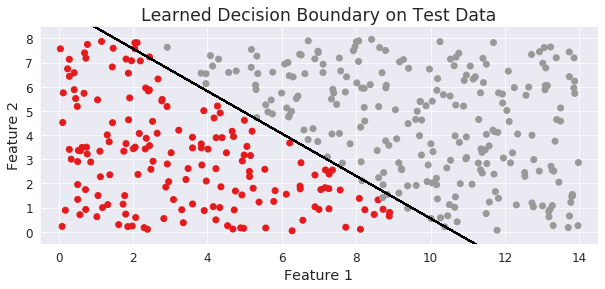

In [11]:
plt.figure(figsize = (10, 4))
plt.scatter(x_test.col_0, x_test.col_1, c = y_test, cmap = 'Set1')
plt.plot(x_test.col_0, split_line, c = 'black')
plt.title('Learned Decision Boundary on Test Data', fontsize = 'xx-large')
plt.xlabel('Feature 1', fontsize = 'x-large')
plt.ylabel('Feature 2', fontsize = 'x-large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.xlim(-0.5, 14.5)
plt.ylim(-0.5, 8.5)
plt.savefig('linear_split_learned.png')
plt.show()

### Polynomial Split across two variables

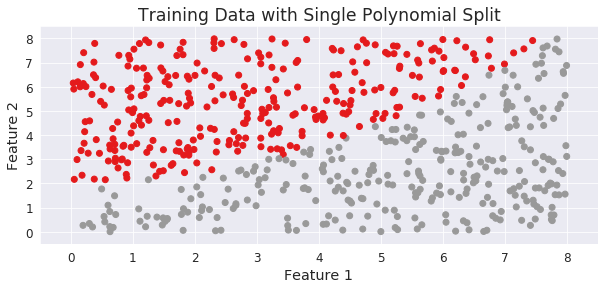

LRCT Performance:
Accuracy: 0.8475
F1 Score: 0.8398950131233597
Confusion Matrix: [[179  13]
 [ 48 160]]
AUC Score: 0.8507612179487178
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       192
           1       0.92      0.77      0.84       208

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400




CART Performance:
Accuracy: 0.8175
F1 Score: 0.8021680216802167
Confusion Matrix: [[179  13]
 [ 60 148]]
AUC Score: 0.8219150641025641
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       192
           1       0.92      0.71      0.80       208

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.84      0.82      0.82       400



In [77]:
#Generate the fake data
np.random.seed(5648)
two_var_x = np.random.random((1000, 2))
two_var_x[:, 0] = two_var_x[:, 0] * 8
two_var_x[:, 1] = two_var_x[:, 1] * 8
df = pd.DataFrame(two_var_x, columns = ['col_0', 'col_1'])
target = df.apply(lambda row : 1 if 0.1*row.col_0**2 > row.col_1 - 2 else 0, axis = 1)
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size = 0.4, random_state = 21)

#Plot the data
plt.figure(figsize = (10, 4))
plt.scatter(x_train.col_0, x_train.col_1, c = y_train, cmap = 'Set1')
plt.title('Training Data with Single Polynomial Split', fontsize = 'xx-large')
plt.xlabel('Feature 1', fontsize = 'x-large')
plt.ylabel('Feature 2', fontsize = 'x-large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.xlim(-0.5, 8.5)
plt.ylim(-0.5, 8.5)
plt.savefig('poly_split_initial.png')
plt.show()
lrct, cart = run_expt({'max_depth' : 1, 'highest_degree' : 2, 'n_bins' : 10, 'method' : 'ols'}, {'max_depth' : 1}, x_train, x_test, y_train, y_test)

In [78]:
lrct.describe()

ID: 0, Parent ID: None, Depth: 0, Split: ('0.06521236265750244*col_0 + 0.08867319043990116*col_0^2 - col_1', -2.830113405902467)
-ID: 1, Parent ID: 0, Depth: 1, Split: nan
-ID: 2, Parent ID: 0, Depth: 1, Split: nan


In [81]:
intercept = -2.830113405902467
coef1 = 0.06521236265750244
coef2 = 0.08867319043990116
col = np.arange(-0, 8, 0.1)
split_curve = coef1*col + coef2*col**2 - intercept

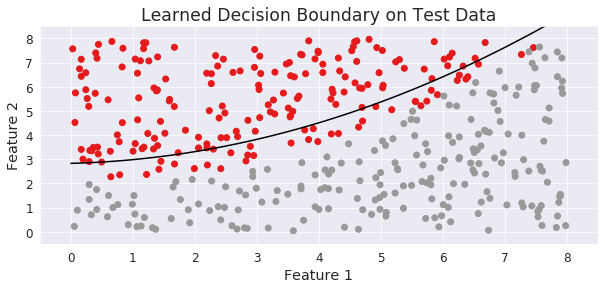

In [83]:
plt.figure(figsize = (10, 4))
plt.scatter(x_test.col_0, x_test.col_1, c = y_test, cmap = 'Set1')
plt.plot(col, split_curve, c = 'black')
plt.title('Learned Decision Boundary on Test Data', fontsize = 'xx-large')
plt.xlabel('Feature 1', fontsize = 'x-large')
plt.ylabel('Feature 2', fontsize = 'x-large')
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.xlim(-.5, 8.5)
plt.ylim(-.5, 8.5)
plt.savefig('poly_split_learned.png')
plt.show()

### Across 2 Variables, Additional Variables, no Noise

In [8]:
#Generate the fake data
np.random.seed(5648)
two_var_x = np.random.random((1000, 10))
two_var_x[:, 0] = two_var_x[:, 0] * 14
two_var_x[:, 1] = two_var_x[:, 1] * 8

df = pd.DataFrame(two_var_x, columns = [f'col_{i}' for i in range(10)])
target = df.apply(lambda row : 1 if row.col_1 > -1*row.col_0 + 2*row.col_6 + 10 else 0, axis = 1)
display(df.head())
display(target.value_counts())

x_train, x_test, y_train, y_test = train_test_split(df, target, test_size = 0.4, random_state = 21)
display(y_test.value_counts())

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,0.526561,4.588875,0.528552,0.811303,0.963880,0.572281,0.288227,0.977607,0.526570,0.736924
1,5.637130,3.412889,0.989832,0.899133,0.498617,0.598368,0.704547,0.972985,0.275137,0.345230
2,0.714066,3.811455,0.694902,0.179677,0.943785,0.116094,0.895479,0.286599,0.171343,0.288328
3,13.720477,7.976714,0.763154,0.903692,0.830631,0.698605,0.352079,0.190098,0.697168,0.577805
4,7.769528,4.866656,0.703745,0.288501,0.440483,0.875562,0.765414,0.051112,0.067182,0.655207


1    505
0    495
dtype: int64

0    202
1    198
dtype: int64

In [9]:
lrct = LRCTree(max_depth = 1, n_independent = 2).fit(x_train, y_train)
print('LRCT Decision Tree Structure:')
lrct.describe()
print('\n')
print(f'LRCT Accuracy Score: {lrct.score(x_test, y_test)}')

cart = DecisionTreeClassifier(max_depth = 1).fit(x_test, y_test)
print(f'CART Score: {cart.score(x_test, y_test)}')

LRCT Decision Tree Structure:
ID: 0, Parent ID: None, Depth: 0, Split: ('0.2185577102905232*col_0 + 0.21714806362032943*col_1 - col_6', 1.7681742047149691)
-ID: 1, Parent ID: 0, Depth: 1, Split: nan
-ID: 2, Parent ID: 0, Depth: 1, Split: nan


LRCT Accuracy Score: 0.96
CART Score: 0.865


### TODO
- Checkerboard
- Two variables, noise, w+w/o nonlinear
- Multiple variables, noise, w+w/o nonlinear
- Other datasets

### Iris Dataset

I'm including the following to show how LRCT is mostly (if not fully) developed into a scikit-learn classifier.  Two big things for scikit-learn classifiers are:

1. Use in scikit-learn GridSearchCV objects
2. Integration into scikit-learn Pipeline objects

The following will show these features on the well-known Breast Cancer dataset

In [10]:
cancer_data = load_breast_cancer()
x = pd.DataFrame(cancer_data['data'], columns = cancer_data['feature_names'])
y = pd.Series(cancer_data['target'])
x_train, x_test, y_train, y_test = train_test_split(x, y)
x_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
122,24.25,20.20,166.20,1761.0,0.14470,0.28670,0.42680,0.201200,0.2655,0.06877,...,26.02,23.99,180.90,2073.0,0.16960,0.42440,0.5803,0.22480,0.3222,0.08009
254,19.45,19.33,126.50,1169.0,0.10350,0.11880,0.13790,0.085910,0.1776,0.05647,...,25.70,24.57,163.10,1972.0,0.14970,0.31610,0.4317,0.19990,0.3379,0.08950
414,15.13,29.81,96.71,719.5,0.08320,0.04605,0.04686,0.027390,0.1852,0.05294,...,17.26,36.91,110.10,931.4,0.11480,0.09866,0.1547,0.06575,0.3233,0.06165
231,11.32,27.08,71.76,395.7,0.06883,0.03813,0.01633,0.003125,0.1869,0.05628,...,12.08,33.75,79.82,452.3,0.09203,0.14320,0.1089,0.02083,0.2849,0.07087
561,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.000000,0.1060,0.05502,...,11.92,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905


# Let's start with the GridSearchCV object
lrct_params = {
    'max_depth' : range(1, 5),
    'min_samples_split' : range(2, 4),
    'n_independent' : range(1, 3),
    'highest_degree' : range(1, 3),
    'method' : ['ols', 'ridge', 'lasso']
}

cart_params = {
    'max_depth' : range(1, 5),
    'min_samples_split' : range(2, 11)
}

lrct_searcher = GridSearchCV(LRCTree(), lrct_params, n_jobs = 10, iid = True, cv = 2, verbose = 2).fit(x_train, y_train)
cart_searcher = GridSearchCV(DecisionTreeClassifier(), cart_params, n_jobs = 10, iid = True, cv = 2, verbose = 2).fit(x_train, y_train)

print(f'LRCT Best Parameters: {lrct_searcher.best_params_}')
print(f'CART Best Parameters: {cart_searcher.best_params_}')
print(f'LRCT Test Accuracy: {lrct_searcher.score(x_test, y_test)}')
print(f'CART Test Accuracy: {cart_searcher.score(x_test, y_test)}')

# Now for pipeline
steps = [
    ('scaler', MinMaxScaler()),
    ('dataframer', FunctionTransformer(lambda x : pd.DataFrame(x, columns = cancer_data['feature_names']))),
    ('clf', LRCTree(highest_degree = 1, max_depth = 2, method = 'ridge', min_samples_split = 2, n_independent = 2))
]

pipeline = Pipeline(steps).fit(x_train, y_train)
print(f'Accuracy: {pipeline.score(x_test, y_test)}')